### 0. Components of Black-Scholes Model

C = call option price

K = strike price

S = underlying spot price

r = interest rate

t = time to expiration

σ = volatility(given by percentage term)

N = normal distribution CDF

### 0.Assumption made for B-S Model:

1.Only to be used for European options.

2.No dividends being paid over the life of the option.

3.No transaction or commisions paid.

4.The underlying price is normally distributed. 

In [1]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame
import pandas_datareader.data as web
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 1. D1, D2, Call, Put Price Calculation

In [2]:
#define d1 & d2
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

In [3]:
#define the functions that calculates call and put prices
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma))-S*norm.cdf(-d1(S,K,T,r,sigma))

### 2. Specify Stock, Expiration, and Strike, Retrieve Data

In [4]:
#specify the underlying, expiration and strike price
stock = 'TSLA'
expiry = '12-30-2022'
strike_price = 155

In [5]:
#get the current date and the date of a year ago
#set the time period
today = datetime.now()
one_year_ago = today.replace(year=today.year-1)
one_year_ago

datetime.datetime(2021, 12, 15, 11, 0, 24, 911524)

In [6]:
#read the data from yahoo finance
df = web.DataReader(stock, 'yahoo', one_year_ago, today)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-15,326.250000,309.416656,317.736664,325.329987,75169200.0,325.329987
2021-12-16,331.660004,307.283325,331.500000,308.973328,82771500.0,308.973328
2021-12-17,320.220001,303.013336,304.923340,310.856659,100437300.0,310.856659
2021-12-20,307.230011,297.796661,303.566681,299.980011,56480100.0,299.980011
2021-12-21,313.166656,295.373322,305.623322,312.843323,71517900.0,312.843323
...,...,...,...,...,...,...
2022-12-08,175.199997,169.059998,172.199997,173.440002,97624500.0,173.440002
2022-12-09,182.500000,173.360001,173.839996,179.050003,104746600.0,179.050003
2022-12-12,177.369995,167.520004,176.100006,167.820007,109794500.0,167.820007


In [7]:
#data cleaning
df = df.sort_values(by="Date")
df = df.dropna()

#get the returns compared to previous date
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)
df

,High,Low,Open,Close,Volume,Adj Close,close_day_before,returns
Date,,,,,,,,
2021-12-15,326.250000,309.416656,317.736664,325.329987,75169200.0,325.329987,NaN,NaN
2021-12-16,331.660004,307.283325,331.500000,308.973328,82771500.0,308.973328,325.329987,-0.050277
2021-12-17,320.220001,303.013336,304.923340,310.856659,100437300.0,310.856659,308.973328,0.006095
2021-12-20,307.230011,297.796661,303.566681,299.980011,56480100.0,299.980011,310.856659,-0.034989
2021-12-21,313.166656,295.373322,305.623322,312.843323,71517900.0,312.843323,299.980011,0.042881
...,...,...,...,...,...,...,...,...
2022-12-08,175.199997,169.059998,172.199997,173.440002,97624500.0,173.440002,174.039993,-0.003447
2022-12-09,182.500000,173.360001,173.839996,179.050003,104746600.0,179.050003,173.440002,0.032345
2022-12-12,177.369995,167.520004,176.100006,167.820007,109794500.0,167.820007,179.050003,-0.062720


### 3. Volatility, Interest, Underlying Price & Time to Expiration

In [8]:
#volatility
sigma = np.sqrt(252) * df['returns'].std()
sigma

0.6511090185100523

In [9]:
#interest rate
uty = (web.DataReader("^TNX", 'yahoo', today.replace(day=today.day-1), today)['Close'].iloc[-1])/100
uty

0.03502999782562256

In [10]:
#underlying price
lcp = df['Close'].iloc[-1]
lcp

156.8000030517578

In [11]:
#time to expiration
t = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365
t

0.038356164383561646

### 4. Option Value Calculation

In [12]:
#theoretical option price
print('The Call Option Price is: ', bs_call(lcp, strike_price, t, uty, sigma))

The Call Option Price is:  8.96476538269063


In [13]:
#a general function that takes 3 inputs and spit out the call, put price
def stock_to_value(stock,expiry,strike_price):
    today = datetime.now()
    one_year_ago = today.replace(year=today.year-1)
    
    df = web.DataReader(stock, 'yahoo', one_year_ago, today)
    df = df.sort_values(by="Date")
    df = df.dropna()
    df = df.assign(close_day_before=df.Close.shift(1))
    df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)
    
    sigma = np.sqrt(252) * df['returns'].std()
    uty = (web.DataReader("^TNX", 'yahoo', today.replace(day=today.day-1), today)['Close'].iloc[-1])/100
    lcp = df['Close'].iloc[-1]
    t = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365
    
    print('The Call Option Price is: ', bs_call(lcp, strike_price, t, uty, sigma))
    print('The Put Option Price is: ', bs_put(lcp, strike_price, t, uty, sigma))

In [14]:
#demonstration
stock_to_value('TSLA', '12-30-2022',155)

The Call Option Price is:  8.96476538269063
The Put Option Price is:  6.956641644403959


### 5.Volatility & Underlying Price Risk Analysis

In [29]:
#get the current volatilty and round to 2 decimals
sig = sigma.round(2)
sig

0.65

In [32]:
#get the underlying price and round to 2 decimals
lcp = lcp.round(2)
lcp

156.8

In [31]:
current_price = bs_call(lcp,strike_price, t, uty, sig)
current_price

8.951360414718067

In [17]:
#50-150% changes
x = 0.5
y = []
while x <1.55:
    y.append(x)
    x+=0.05

y

[0.5,
 0.55,
 0.6000000000000001,
 0.6500000000000001,
 0.7000000000000002,
 0.7500000000000002,
 0.8000000000000003,
 0.8500000000000003,
 0.9000000000000004,
 0.9500000000000004,
 1.0000000000000004,
 1.0500000000000005,
 1.1000000000000005,
 1.1500000000000006,
 1.2000000000000006,
 1.2500000000000007,
 1.3000000000000007,
 1.3500000000000008,
 1.4000000000000008,
 1.4500000000000008,
 1.5000000000000009]

In [18]:
#50-150% of the current volatility
z = []
for i in y:
    z.append(i*sig)
z

[0.325,
 0.35750000000000004,
 0.39000000000000007,
 0.4225000000000001,
 0.4550000000000001,
 0.48750000000000016,
 0.5200000000000002,
 0.5525000000000002,
 0.5850000000000003,
 0.6175000000000003,
 0.6500000000000004,
 0.6825000000000003,
 0.7150000000000004,
 0.7475000000000004,
 0.7800000000000005,
 0.8125000000000004,
 0.8450000000000005,
 0.8775000000000005,
 0.9100000000000006,
 0.9425000000000006,
 0.9750000000000006]

In [19]:
#90-110% changes
v = 0.9
w = []
while v <1.11:
    w.append(v)
    v+=0.01
w

[0.9,
 0.91,
 0.92,
 0.93,
 0.9400000000000001,
 0.9500000000000001,
 0.9600000000000001,
 0.9700000000000001,
 0.9800000000000001,
 0.9900000000000001,
 1.0,
 1.01,
 1.02,
 1.03,
 1.04,
 1.05,
 1.06,
 1.07,
 1.08,
 1.09,
 1.1]

In [20]:
#90-110% of the current underlying price
u = []
for i in w:
    u.append(i*lcp)
u

[141.12,
 142.68800000000002,
 144.25600000000003,
 145.824,
 147.39200000000002,
 148.96,
 150.52800000000002,
 152.09600000000003,
 153.66400000000002,
 155.23200000000003,
 156.8,
 158.36800000000002,
 159.936,
 161.50400000000002,
 163.07200000000003,
 164.64000000000001,
 166.20800000000003,
 167.776,
 169.34400000000002,
 170.91200000000003,
 172.48000000000002]

In [21]:
#create dataframe with volatility and underlying price
df = pd.DataFrame(list(product(z, u)), columns=['volatility', 'underlying_price'])
df['volatility'] = df['volatility'].round(2)
df['underlying_price'] = df['underlying_price'].round(2)
df

,volatility,underlying_price
0,0.32,141.12
1,0.32,142.69
2,0.32,144.26
3,0.32,145.82
4,0.32,147.39
...,...,...
436,0.98,166.21
437,0.98,167.78
438,0.98,169.34
439,0.98,170.91


In [22]:
#calculate option value given different volatility & underlying price
option_values = []
for i in z:
    for x in u:
        option_values.append(bs_call(x,strike_price, t, uty, i))

option_values = [i.round(2) for i in option_values]
option_values


[0.31,
 0.45,
 0.64,
 0.9,
 1.22,
 1.62,
 2.11,
 2.7,
 3.38,
 4.16,
 5.04,
 6.02,
 7.08,
 8.23,
 9.46,
 10.75,
 12.09,
 13.49,
 14.92,
 16.39,
 17.88,
 0.45,
 0.63,
 0.86,
 1.15,
 1.51,
 1.95,
 2.47,
 3.07,
 3.77,
 4.55,
 5.43,
 6.39,
 7.44,
 8.56,
 9.75,
 11.01,
 12.32,
 13.68,
 15.09,
 16.52,
 17.99,
 0.62,
 0.83,
 1.1,
 1.42,
 1.82,
 2.28,
 2.83,
 3.45,
 4.16,
 4.95,
 5.82,
 6.77,
 7.8,
 8.9,
 10.07,
 11.29,
 12.58,
 13.91,
 15.28,
 16.69,
 18.13,
 0.81,
 1.06,
 1.35,
 1.71,
 2.13,
 2.63,
 3.19,
 3.83,
 4.55,
 5.34,
 6.21,
 7.15,
 8.17,
 9.25,
 10.39,
 11.59,
 12.85,
 14.15,
 15.5,
 16.88,
 18.29,
 1.02,
 1.3,
 1.63,
 2.01,
 2.46,
 2.97,
 3.56,
 4.21,
 4.94,
 5.73,
 6.6,
 7.53,
 8.54,
 9.6,
 10.73,
 11.91,
 13.14,
 14.42,
 15.73,
 17.09,
 18.48,
 1.25,
 1.55,
 1.91,
 2.32,
 2.79,
 3.33,
 3.93,
 4.59,
 5.33,
 6.12,
 6.99,
 7.92,
 8.91,
 9.96,
 11.07,
 12.23,
 13.44,
 14.69,
 15.99,
 17.32,
 18.69,
 1.49,
 1.82,
 2.2,
 2.64,
 3.13,
 3.68,
 4.3,
 4.98,
 5.72,
 6.52,
 7.38,
 8.31,
 9.29

In [33]:
#add option value into the df
df['option_value'] = option_values
df['option_changes'] = df['option_value'] - current_price
df

,volatility,underlying_price,option_value,option_changes
0,0.32,141.12,0.31,-8.64136
1,0.32,142.69,0.45,-8.50136
2,0.32,144.26,0.64,-8.31136
3,0.32,145.82,0.90,-8.05136
4,0.32,147.39,1.22,-7.73136
...,...,...,...,...
436,0.98,166.21,18.75,9.79864
437,0.98,167.78,19.83,10.87864
438,0.98,169.34,20.94,11.98864
439,0.98,170.91,22.07,13.11864


In [24]:
#create a table for heatmap
df_pivoted = df.pivot('volatility','underlying_price','option_value')
df_pivoted

underlying_price,141.12,142.69,144.26,145.82,147.39,148.96,150.53,152.10,153.66,155.23,...,158.37,159.94,161.50,163.07,164.64,166.21,167.78,169.34,170.91,172.48
volatility,,,,,,,,,,,,,,,,,,,,,
0.32,0.31,0.45,0.64,0.90,1.22,1.62,2.11,2.70,3.38,4.16,...,6.02,7.08,8.23,9.46,10.75,12.09,13.49,14.92,16.39,17.88
0.36,0.45,0.63,0.86,1.15,1.51,1.95,2.47,3.07,3.77,4.55,...,6.39,7.44,8.56,9.75,11.01,12.32,13.68,15.09,16.52,17.99
0.39,0.62,0.83,1.10,1.42,1.82,2.28,2.83,3.45,4.16,4.95,...,6.77,7.80,8.90,10.07,11.29,12.58,13.91,15.28,16.69,18.13
0.42,0.81,1.06,1.35,1.71,2.13,2.63,3.19,3.83,4.55,5.34,...,7.15,8.17,9.25,10.39,11.59,12.85,14.15,15.50,16.88,18.29
0.46,1.02,1.30,1.63,2.01,2.46,2.97,3.56,4.21,4.94,5.73,...,7.53,8.54,9.60,10.73,11.91,13.14,14.42,15.73,17.09,18.48
0.49,1.25,1.55,1.91,2.32,2.79,3.33,3.93,4.59,5.33,6.12,...,7.92,8.91,9.96,11.07,12.23,13.44,14.69,15.99,17.32,18.69
0.52,1.49,1.82,2.20,2.64,3.13,3.68,4.30,4.98,5.72,6.52,...,8.31,9.29,10.33,11.42,12.56,13.75,14.99,16.26,17.57,18.92
0.55,1.74,2.10,2.50,2.96,3.48,4.04,4.67,5.36,6.11,6.91,...,8.69,9.67,10.70,11.78,12.90,14.08,15.29,16.55,17.84,19.16
0.59,2.01,2.39,2.81,3.29,3.82,4.41,5.05,5.74,6.50,7.30,...,9.08,10.05,11.07,12.14,13.25,14.41,15.61,16.84,18.11,19.42


In [34]:
df_pivoted_2 = df.pivot('volatility','underlying_price','option_changes')
df_pivoted_2

underlying_price,141.12,142.69,144.26,145.82,147.39,148.96,150.53,152.10,153.66,155.23,...,158.37,159.94,161.50,163.07,164.64,166.21,167.78,169.34,170.91,172.48
volatility,,,,,,,,,,,,,,,,,,,,,
0.32,-8.64136,-8.50136,-8.31136,-8.05136,-7.73136,-7.33136,-6.84136,-6.25136,-5.57136,-4.79136,...,-2.93136,-1.87136,-0.72136,0.50864,1.79864,3.13864,4.53864,5.96864,7.43864,8.92864
0.36,-8.50136,-8.32136,-8.09136,-7.80136,-7.44136,-7.00136,-6.48136,-5.88136,-5.18136,-4.40136,...,-2.56136,-1.51136,-0.39136,0.79864,2.05864,3.36864,4.72864,6.13864,7.56864,9.03864
0.39,-8.33136,-8.12136,-7.85136,-7.53136,-7.13136,-6.67136,-6.12136,-5.50136,-4.79136,-4.00136,...,-2.18136,-1.15136,-0.05136,1.11864,2.33864,3.62864,4.95864,6.32864,7.73864,9.17864
0.42,-8.14136,-7.89136,-7.60136,-7.24136,-6.82136,-6.32136,-5.76136,-5.12136,-4.40136,-3.61136,...,-1.80136,-0.78136,0.29864,1.43864,2.63864,3.89864,5.19864,6.54864,7.92864,9.33864
0.46,-7.93136,-7.65136,-7.32136,-6.94136,-6.49136,-5.98136,-5.39136,-4.74136,-4.01136,-3.22136,...,-1.42136,-0.41136,0.64864,1.77864,2.95864,4.18864,5.46864,6.77864,8.13864,9.52864
0.49,-7.70136,-7.40136,-7.04136,-6.63136,-6.16136,-5.62136,-5.02136,-4.36136,-3.62136,-2.83136,...,-1.03136,-0.04136,1.00864,2.11864,3.27864,4.48864,5.73864,7.03864,8.36864,9.73864
0.52,-7.46136,-7.13136,-6.75136,-6.31136,-5.82136,-5.27136,-4.65136,-3.97136,-3.23136,-2.43136,...,-0.64136,0.33864,1.37864,2.46864,3.60864,4.79864,6.03864,7.30864,8.61864,9.96864
0.55,-7.21136,-6.85136,-6.45136,-5.99136,-5.47136,-4.91136,-4.28136,-3.59136,-2.84136,-2.04136,...,-0.26136,0.71864,1.74864,2.82864,3.94864,5.12864,6.33864,7.59864,8.88864,10.20864
0.59,-6.94136,-6.56136,-6.14136,-5.66136,-5.13136,-4.54136,-3.90136,-3.21136,-2.45136,-1.65136,...,0.12864,1.09864,2.11864,3.18864,4.29864,5.45864,6.65864,7.88864,9.15864,10.46864


<AxesSubplot:xlabel='underlying_price', ylabel='volatility'>

<AxesSubplot:xlabel='underlying_price', ylabel='volatility'>

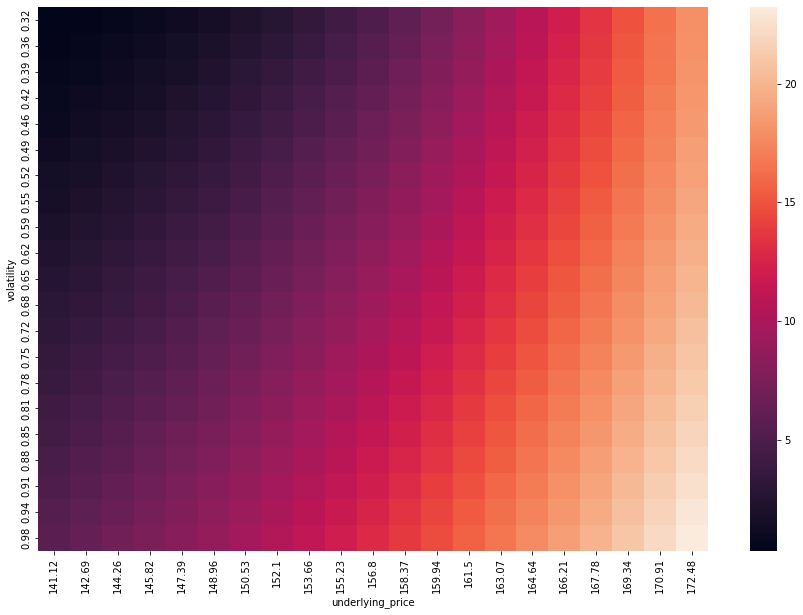

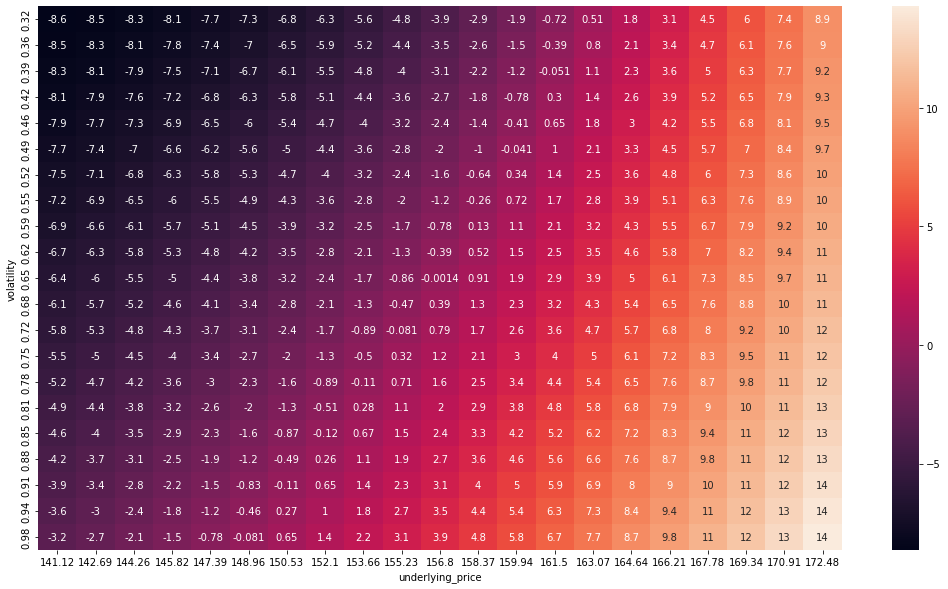

In [38]:
#call option values risk change heatmap
fig, ax = plt.subplots(figsize = (15,10)) 
sns.heatmap(df_pivoted, ax = ax)

fig, ax = plt.subplots(figsize = (18,10)) 
sns.heatmap(df_pivoted_2, ax = ax, annot = True)

In [39]:
#combine everything into one function for heatmap
def v_d_risk_heatmap(stock,expiry,strike_price):
    today = datetime.now()
    one_year_ago = today.replace(year=today.year-1)
    #source the data from yahoo finance
    df = web.DataReader(stock, 'yahoo', one_year_ago, today)
    df = df.sort_values(by="Date")
    df = df.dropna()
    df = df.assign(close_day_before=df.Close.shift(1))
    df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)
    #main inputs
    sigma = np.sqrt(252) * df['returns'].std()
    uty = (web.DataReader("^TNX", 'yahoo', today.replace(day=today.day-1), today)['Close'].iloc[-1])/100
    lcp = df['Close'].iloc[-1]
    t = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365
    #get the current volatility, underlying price and current option value
    sig = sigma.round(2)
    lcp = lcp.round(2)
    current_price = bs_call(lcp,strike_price, t, uty, sig)
    #get +-50% volatility value
    x = 0.5
    y = []
    while x <1.55:
        y.append(x)
        x+=0.05
    
    z = []
    for i in y:
        z.append(i*sig)
    #get +-10% underlying value
    v = 0.9
    w = []
    while v <1.11:
        w.append(v)
        v+=0.01
    
    u = []
    for i in w:
        u.append(i*lcp)
    #create dataframe with volatility and underlying price
    df = pd.DataFrame(list(product(z, u)), columns=['volatility', 'underlying_price'])
    df['volatility'] = df['volatility'].round(2)
    df['underlying_price'] = df['underlying_price'].round(2)
    
    #calculate option value given different volatility & underlying price
    option_values = []
    for i in z:
        for x in u:
            option_values.append(bs_call(x,strike_price, t, uty, i))
    option_values = [i.round(2) for i in option_values]
    df['option_value'] = option_values
    df['option_changes'] = df['option_value'] - current_price
    
    #create a table for heatmap and plot
    df_pivoted = df.pivot('volatility','underlying_price','option_value')
    df_pivoted_2 = df.pivot('volatility','underlying_price','option_changes')
    
    fig, ax = plt.subplots(figsize = (15,10)) 
    sns.heatmap(df_pivoted, ax = ax, cmap = 'GnBu')
    
    fig, ax = plt.subplots(figsize = (18,10)) 
    sns.heatmap(df_pivoted_2, ax = ax, cmap = 'GnBu',annot = True)

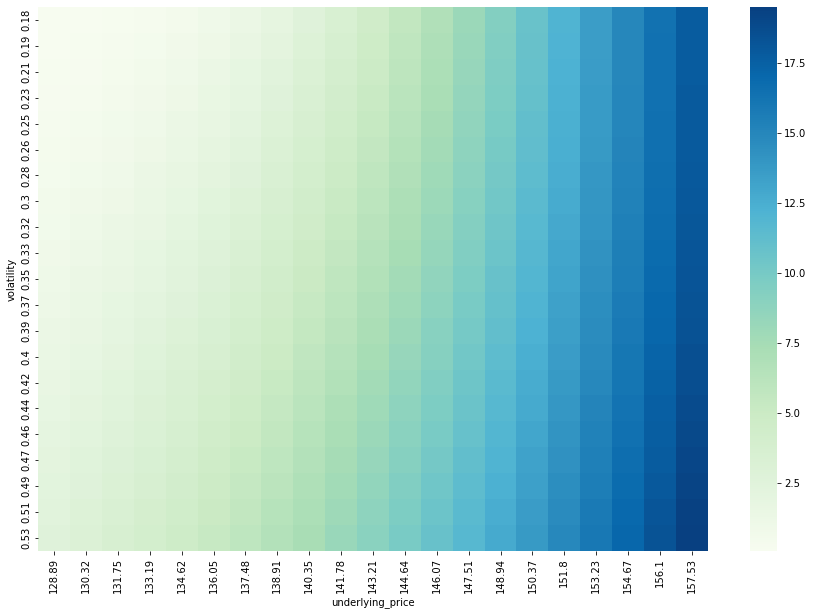

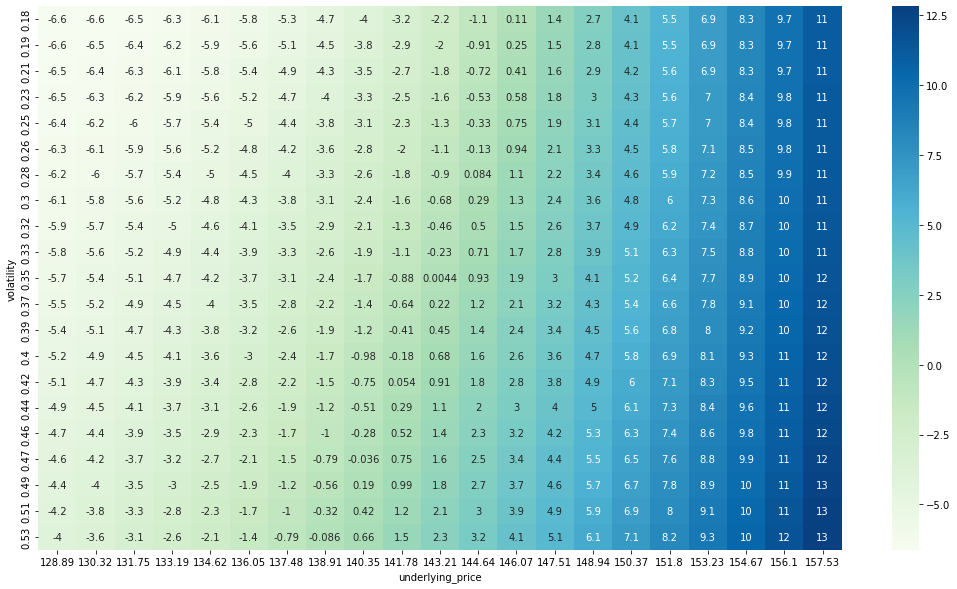

In [40]:
#demonstration 
v_d_risk_heatmap('AAPL','01-06-2023', 140)